   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
After Processing:-
   weather  temperature  cnt  hour  day_of_week
0        0         0.24   16     0            6
1        0         0.22   40     1            6
2        0         0.22   32     2            6
RMSE: 88.16245262999722
Best parameters: {'max_depth': 10, 'n_estimators': 300}
Predicted ride requests for 17:00 on day 6 with temperature 44.0°C and weather 1 : 270


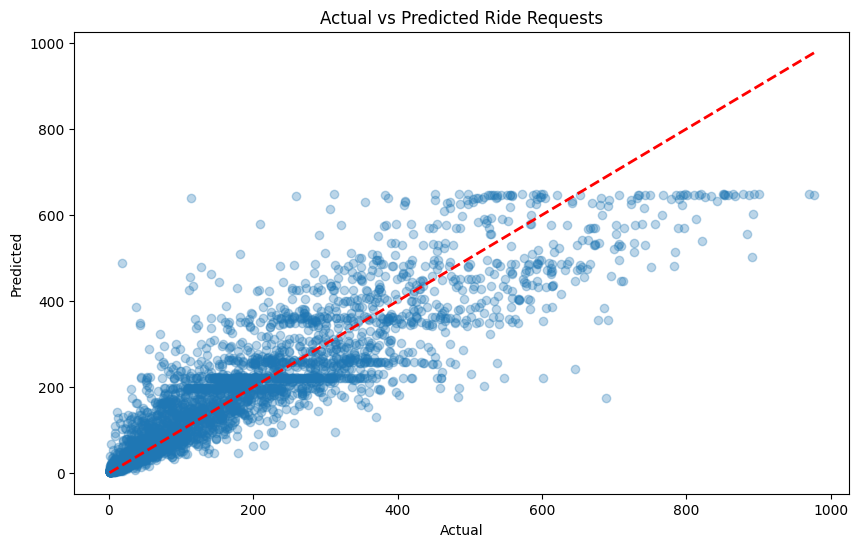

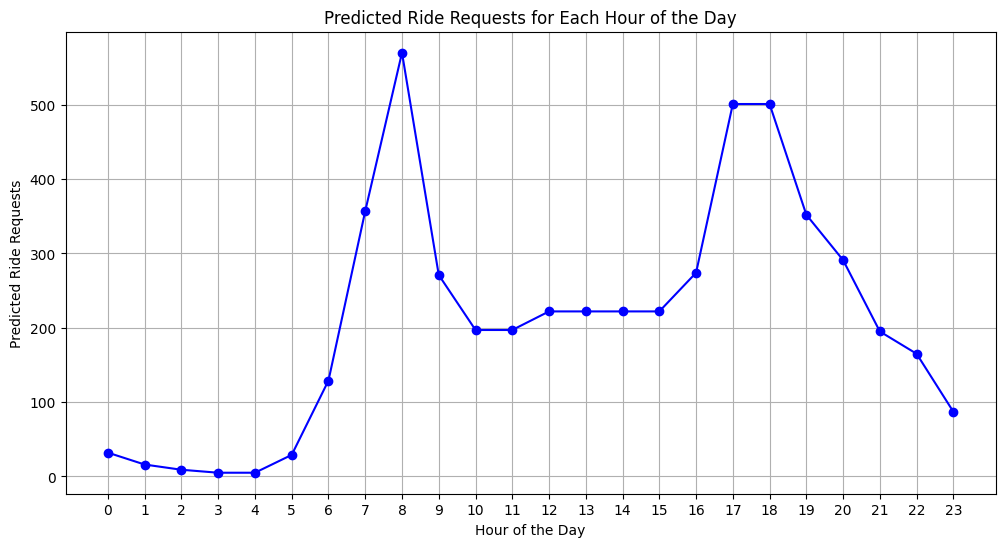

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
data = pd.read_csv("/content/sample_data/hour.csv")
print(data.head(3))

# Handle missing values if necessary
data.ffill(inplace=True)

# Convert 'weathersit' to categorical codes
data['weathersit'] = data['weathersit'].astype('category').cat.codes

# Rename columns to match the previous example
data.rename(columns={'weathersit': 'weather', 'temp': 'temperature'}, inplace=True)

# Extract relevant features
data['hour'] = data['hr']
data['day_of_week'] = data['weekday']

# Drop unnecessary columns
columns_to_drop = ['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'atemp', 'hum', 'windspeed', 'casual', 'registered']
data.drop(columns=columns_to_drop, inplace=True)

# Display the preprocessed data
print("After Processing:-")
print(data.head(3))

# Split the data into features and target
X = data.drop(columns=['cnt'])
y = data['cnt']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Use the best model to make predictions
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_best = best_model.predict(X_test)

# Ensure the feature order matches the training data
feature_names = X.columns.tolist()

# Function to predict ride requests for a specific hour
def predict_ride_requests(hour, day_of_week, temperature, weather, model, feature_names):
    input_data = pd.DataFrame({
        'hour': [hour],
        'day_of_week': [day_of_week],
        'temperature': [temperature],
        'weather': [weather]
    })
    input_data = input_data[feature_names]
    # Predict ride requests
    prediction = model.predict(input_data)
    return round(prediction[0])

# Example usage of the prediction function
hour = 17
day_of_week = 6
temperature = 0.44
weather = 1  # Clear weather

predicted_requests = predict_ride_requests(hour, day_of_week, temperature, weather, best_model, feature_names)
print(f'Predicted ride requests for {hour}:00 on day {day_of_week} with temperature {temperature*100}°C and weather {weather} : {predicted_requests}')

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Ride Requests')
plt.show()

# Predict ride requests for each hour of the day with fixed day_of_week, temperature, and weather conditions
hours = np.arange(0, 24)
day_of_week = 3  # Assuming a Wednesday
temperature = 0.5  # Example temperature
weather = 1  # Clear weather

predicted_requests = [
    predict_ride_requests(hour, day_of_week, temperature, weather, best_model, feature_names)
    for hour in hours
]

# Plot the predicted ride requests versus hour of the day
plt.figure(figsize=(12, 6))
plt.plot(hours, predicted_requests, marker='o', linestyle='-', color='b')
plt.xticks(hours)
plt.xlabel('Hour of the Day')
plt.ylabel('Predicted Ride Requests')
plt.title('Predicted Ride Requests for Each Hour of the Day')
plt.grid(True)
plt.show()
